In [15]:
import laspy

In [17]:
new_las = laspy.create(file_version="1.2", point_format=3)

In [ ]:
print(new_las)

In [4]:
print(type(new_las.X))

<class 'numpy.ndarray'>


In [34]:
import json

# ALREADY WITTEN FUNCS HERE

def list_dump(input_list,outpath,mode='w+'):
    with open(outpath,mode) as list_writer:
        for item in input_list:
            list_writer.write(str(item)+'\n')

def print_rem_time_info(total_it,curent_it,ref_time,chunk_size=1):
    # "it" stands for 'iteration'
    it_time  = time.time()-ref_time
    rem_its  = total_it-curent_it
    rem_time = it_time * rem_its
    print("{} iter took {:.4f} seconds, estimated remaining time: {:.4f} minutes or {:.4f} hours, iteration {} of {}".format(chunk_size,it_time*chunk_size,rem_time/60.0,rem_time/3600.0,curent_it,total_it))


In [29]:
import subprocess

# NEW FUNCS HERE

def parse_json(jsonpath):
    with open(jsonpath) as reader:
        return json.load(reader)

def gdal_vrt_from_filelist(filelistpath,outputpath,print_runstring=True):

    runstring = f'gdalbuildvrt -input_file_list {filelistpath} {outputpath}'

    if(print_runstring):
        print(runstring)

    subprocess.run(runstring,shell=True)

def gdal_translate_dem(imagepath,outpath,bbox_minxy_maxxy=None,outformat='XYZ',boundaries_epsg='4326',custom_cellsize=None,enlargement_percent=None,print_runstring=True):
    '''
        bbox must be given as a list in guessed order
    '''

    bbox_part = ''

    if bbox_minxy_maxxy:

        ulx = bbox_minxy_maxxy[0]
        uly = bbox_minxy_maxxy[3]
        lrx = bbox_minxy_maxxy[1]
        lry = bbox_minxy_maxxy[2]

        bbox_part = f'-projwin {ulx} {uly} {lrx} {lry} -projwin_srs "EPSG:{boundaries_epsg}"'

    cellsize_part = ''

    if custom_cellsize and (not enlargement_percent):
        cellsize_part = f'-r bilinear -tr {custom_cellsize} {custom_cellsize}'

    enlargement_part = ''

    if not custom_cellsize and enlargement_percent:
        cellsize_part = f'-r bilinear -outsize {enlargement_percent}% {enlargement_percent}%'

    runstring = f'gdal_translate {bbox_part} {cellsize_part} {enlargement_part} -of {outformat} {imagepath} {outpath}'

    if(print_runstring):
        print(runstring)

    subprocess.run(runstring,shell=True)



def get_raster_val_at_geoXY(x,y,rasterpath):
    runstring = f'gdallocationinfo -valonly -geoloc {rasterpath} {x} {y}'

    ret = subprocess.run(runstring,shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8')

    return float(ret.strip('\n'))


def string_to_floatlist(inputstring):
    return list(map(float,line.strip('\n').split(' ')))

In [7]:
jsonpath = '/home/kaue/data/sanit3d_out/temporary/dtm_raster_data_dump.json'

dtm_dict = parse_json(jsonpath)

dtm_filename_list = list(dtm_dict['downloaded_image_path'].values())

In [8]:
jsonpath = '/home/kaue/data/sanit3d_out/temporary/dsm_raster_data_dump.json'

dsm_dict = parse_json(jsonpath)

dsm_filename_list = list(dsm_dict['downloaded_image_path'].values())

In [9]:
dtm_filename_list

['/home/kaue/data/sanit3d_out/temporary/DTM_35_776.img',
 '/home/kaue/data/sanit3d_out/temporary/DTM_35_777.img',
 '/home/kaue/data/sanit3d_out/temporary/DTM_36_776.img',
 '/home/kaue/data/sanit3d_out/temporary/DTM_36_777.img',
 '/home/kaue/data/sanit3d_out/temporary/DTM_37_776.img',
 '/home/kaue/data/sanit3d_out/temporary/DTM_37_777.img']

In [10]:
dsm_filename_list

['/home/kaue/data/sanit3d_out/temporary/DSM_35_776.img',
 '/home/kaue/data/sanit3d_out/temporary/DSM_35_777.img',
 '/home/kaue/data/sanit3d_out/temporary/DSM_36_776.img',
 '/home/kaue/data/sanit3d_out/temporary/DSM_36_777.img',
 '/home/kaue/data/sanit3d_out/temporary/DSM_37_776.img',
 '/home/kaue/data/sanit3d_out/temporary/DSM_37_777.img']

In [11]:
dtm_filelist_name = 'test_dtm_list.txt'
dtm_vrt_path = 'test_vrt_dtm.vrt'
list_dump(dtm_filename_list,dtm_filelist_name)

dsm_filelist_name = 'test_dsm_list.txt'
dsm_vrt_path = 'test_vrt_dsm.vrt'
list_dump(dsm_filename_list,dsm_filelist_name)

In [12]:
gdal_vrt_from_filelist(dtm_filelist_name,dtm_vrt_path)
gdal_vrt_from_filelist(dsm_filelist_name,dsm_vrt_path)


gdalbuildvrt -input_file_list test_dtm_list.txt test_vrt_dtm.vrt
gdalbuildvrt -input_file_list test_dsm_list.txt test_vrt_dsm.vrt


In [13]:
lgt_min = -40.3397827083
lgt_max = -40.3353356058
lat_min = -20.3214263926
lat_max = -20.3176282943

bbox_test = [lgt_min,lgt_max,lat_min,lat_max]

In [26]:
# tests 232 * 211 = 48952 spected points

dtm_xyz_path = 'dtm_test.xyz' 

gdal_translate_dem(dtm_vrt_path,dtm_xyz_path,bbox_test)


gdal_translate -projwin -40.3397827083 -20.3176282943 -40.3353356058 -20.3214263926 -projwin_srs "EPSG:4326"   -of XYZ test_vrt_dtm.vrt dtm_test.xyz


In [16]:
dsm_xyz_path = 'dsm_test.xyz' 

gdal_translate_dem(dsm_vrt_path,dsm_xyz_path,bbox_test,custom_cellsize=0.5)

gdal_translate -projwin -40.3397827083 -20.3176282943 -40.3353356058 -20.3214263926 -projwin_srs "EPSG:4326" -r bilinear -tr 0.5 0.5  -of XYZ test_vrt_dsm.vrt dsm_test.xyz


In [35]:
import time

Xlist = []
Ylist = []
Zlist = []
Clist = []

with open(dtm_xyz_path) as reader:
    for i,line in enumerate(reader):
        if i % 100 == 0:
            t1 = time.time()

        X,Y,Z = string_to_floatlist(line)

        Xlist.append(X)
        Ylist.append(Y)
        Zlist.append(Z)
        Clist.append(2)

        dsm_z = get_raster_val_at_geoXY(X,Y,dsm_vrt_path)

        if(dsm_z - Z) > 2:
            Xlist.append(X)
            Ylist.append(Y)
            Zlist.append(dsm_z)
            Clist.append(0)

        if i % 100 == 0:
            print_rem_time_info(48672,i,t1,100)
        

00 iter took 8.9354 seconds, estimated remaining time: 26.1689 minutes or 0.4361 hours, iteration 31100 of 48672
100 iter took 8.7842 seconds, estimated remaining time: 25.5797 minutes or 0.4263 hours, iteration 31200 of 48672
100 iter took 9.0459 seconds, estimated remaining time: 26.1909 minutes or 0.4365 hours, iteration 31300 of 48672
100 iter took 9.3301 seconds, estimated remaining time: 26.8581 minutes or 0.4476 hours, iteration 31400 of 48672
100 iter took 9.1873 seconds, estimated remaining time: 26.2942 minutes or 0.4382 hours, iteration 31500 of 48672
100 iter took 9.2242 seconds, estimated remaining time: 26.2459 minutes or 0.4374 hours, iteration 31600 of 48672
100 iter took 9.3919 seconds, estimated remaining time: 26.5666 minutes or 0.4428 hours, iteration 31700 of 48672
100 iter took 8.8628 seconds, estimated remaining time: 24.9221 minutes or 0.4154 hours, iteration 31800 of 48672
100 iter took 8.8751 seconds, estimated remaining time: 24.8090 minutes or 0.4135 hours, 

1

In [40]:
import laspy
import numpy as np

# my_data_xx, my_data_yy = np.meshgrid(np.linspace(-20, 20, 15), np.linspace(-20, 20, 15))
# my_data_zz = my_data_xx ** 2 + 0.25 * my_data_yy ** 2

# my_data = np.hstack((my_data_xx.reshape((-1, 1)), my_data_yy.reshape((-1, 1)), my_data_zz.reshape((-1, 1))))


las = laspy.create(file_version="1.2", point_format=3)

# las.header.offsets = np.min(my_data, axis=0)
# las.header.scales = [0.1, 0.1, 0.1]

las.x = np.array(Xlist)
las.y = np.array(Ylist)
las.z = np.array(Zlist)
las.classification = np.array(Clist,dtype=np.intc)

las.write("sample_las.las")

In [39]:
np.array(Clist,dtype=np.intc)

array([2, 2, 2, ..., 0, 2, 0], dtype=int32)

In [42]:
# generate terrain polygon
import geopandas as gpd


polygons_geojson_path = '/home/kaue/data/sanit3d_out/temporary/buildings_osm.geojson'

as_gdf = gpd.read_file(polygons_geojson_path)

In [67]:
from shapely import wkt

small_bbox_wkt = 'POLYGON((-40.3397827083 -20.3176282943, -40.3353356058 -20.3176282943, -40.3353356058 -20.3214263926, -40.3397827083 -20.3214263926, -40.3397827083 -20.3176282943))'

bbox_polygon = wkt.loads(small_bbox_wkt)


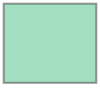

In [68]:
bbox_polygon

In [69]:
data2 = {'name':['bbox'],'geometry':[bbox_polygon]}

bbox_gdf = gpd.GeoDataFrame(data2,crs="EPSG:4326")

In [70]:
clipped = as_gdf.intersection(bbox_polygon)


In [71]:
clipped = clipped[~clipped.is_empty]

In [72]:
# clipping
crs_proj = 'EPSG:31984'

clipped.to_file('clipped_wgs84.geojson',driver='GeoJSON')

clipped.to_crs(crs_proj).to_file('clipped_31984.geojson',driver='GeoJSON')


In [73]:
# symettrical_difference
ground_pol = bbox_gdf.symmetric_difference(clipped.unary_union)

ground_pol.to_file('ground_pol_wgs84.geojson',driver='GeoJSON')

In [74]:
ground_pol.to_crs(crs_proj).to_file('ground_pol_31984.geojson',driver='GeoJSON')